# Augment Segmentation Maps

Segmentation maps are 2D arrays in which every spatial position is assigned to exactly one class. They are represented in `imgaug` using `imgaug.augmentables.segmaps.SegmentationMapsOnImage`. The class is instantiated as `SegmentationMapsOnImage(arr, shape)`. `arr` contains the 2D segmentation map and `shape` is the shape of the corresponding *image* (not of the segmentation map array!). The class is called "...MapsOnImage" and not "...MapOnImage", because you can actually provide many segmentation maps for the same image (provided they all have the same height and width). That means that `arr` may have the shape `(H,W)` or `(H,W,1)`, but it can also have shape `(H,W,C)` with `C>1`. That is useful for e.g. stacked boolean masks or instance segmentation maps (one map of instances per class).

Analogous to the constructor arguments, `SegmentationMapsOnImage` has the attributes `.shape` (shape of the corresponding image) and `.arr` (internal segmentation map representation).

Noteworthy methods of `SegmentationMapsOnImage` are:
  * `get_arr()`: Converts the internal representation of the segmentation map to the same shape and dtype as was originally provided to the constructor. (The internal representation is of shape `(H,W,C)` (with possibly `C=1`) and dtype `int32`.)
  * `draw([size], [colors])`: Converts the segmentation map to an RGB image.
  * `draw_on_image(image, [alpha], [resize], [colors], [draw_background])`: Converts the segmentation map to an RGB image and blends it with a provided image.
  * `pad([top], [right], [bottom], [left], [mode], [cval])`: Pad the segmentation map on its sides.
  * `pad_to_aspect_ratio(aspect_ration, [mode], [cval], [return_pad_amounts])`: Pad the segmentation map to an aspect ratio (`ratio=width/height`).
  * `resize(sizes, [interpolation])`: Resize the segmentation map to the provided size. Uses by default nearest neighbour interpolation.

To augment segmentation maps, use `augment_segmentation_maps()`, which is offered by all augmenters. It expects a single `SegmentationMapsOnImage` instance or a `list` of `SegmentationMapsOnImage` instances. You may also call `augment(image=..., segmentation_map=...)` or its alias `__call__(images=..., segmentation_maps=...)` (e.g. `Affine(scale=1.5)(images=..., segmentation_maps=...)`), which both allow to provide the segmentation map as an int-like array.

For more details, see the [API](https://imgaug.readthedocs.io/en/latest/source/api.html): [imgaug.augmentables.segmaps.SegmentationMapsOnImage](https://imgaug.readthedocs.io/en/latest/source/api_imgaug.html#imgaug.augmentables.segmaps.SegmentationMapsOnImage), [imgaug.augmenters.meta.Augmenter.augment_segmentation_maps()](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_meta.html#imgaug.augmenters.meta.Augmenter.augment_segmentation_maps), [imgaug.augmenters.meta.Augmenter.augment()](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_meta.html#imgaug.augmenters.meta.Augmenter.augment).

For drawing routines `SegmentationMapsOnImage` uses a predefined set of colors. These are currently saved in the constant `SegmentationMapsOnImage.DEFAULT_SEGMENT_COLORS`. They will likely be replaced at some point in the future by a matplotlib colormap.

**Important**: `imgaug`'s segmentation map augmentation is geared towards **ground truth** outputs. As such, only augmentation techniques that change the image geometry will be applied to segmentation maps, even when other augmentation techniques are part of a pipeline. Examples for that are e.g. horizontal flips or affine transformations. To also apply non-geometric augmentation techniques, feed the segmentation map array through `augmenter.augment_images()` instead.

## Creating an Example Segmentation Map from Polygons Given as Points

The goal of our first example is to load an image, create a segmentation map and augment both of them. Let's first load and visualize our example image:

(319, 479, 3)


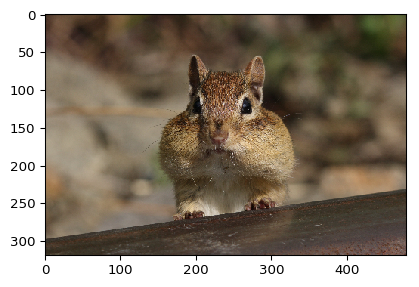

In [1]:
import imageio
import imgaug as ia
%matplotlib inline

image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/f/f4/Tamias_striatus_CT.jpg")
image = ia.imresize_single_image(image, 0.15)
print(image.shape)
ia.imshow(image)

Now we need a segmentation map for that image. We will create two classes, one for the tree (bottom) and one for the chipmunk (center). Everything else will be background. Both classes will be created as polygons and then drawn on a segmentation map array. First, we define the four corner points of the tree polygon:

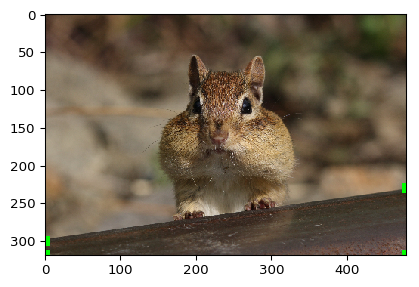

In [2]:
import numpy as np
from imgaug.augmentables.kps import KeypointsOnImage

tree_kps_xy = np.float32([
    [0, 300],  # left top of the tree
    [image.shape[1]-1, 230],  # right top
    [image.shape[1]-1, image.shape[0]-1],  # right bottom
    [0, image.shape[0]-1]  # left bottom
])

# visualize
kpsoi_tree = KeypointsOnImage.from_xy_array(tree_kps_xy, shape=image.shape)
ia.imshow(kpsoi_tree.draw_on_image(image, size=13))

Now we have to create the chipmunk polygon. That one requires significantly more corner points, but the underlying method is the same:

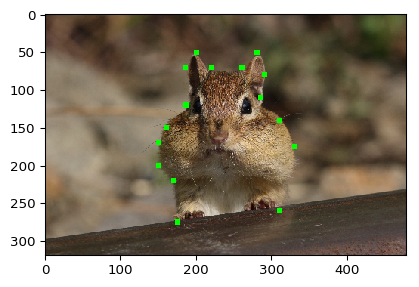

In [3]:
chipmunk_kps_xy = np.float32([
    [200, 50],  # left ear, top (from camera perspective)
    [220, 70],
    [260, 70],
    [280, 50],  # right ear, top
    [290, 80],
    [285, 110],
    [310, 140],
    [330, 175], # right of cheek
    [310, 260], # right of right paw
    [175, 275], # left of left paw
    [170, 220],
    [150, 200],
    [150, 170], # left of cheek
    [160, 150],
    [186, 120], # left of eye
    [185, 70]
])

# visualize
kpsoi_chipmunk = KeypointsOnImage.from_xy_array(chipmunk_kps_xy, shape=image.shape)
ia.imshow(kpsoi_chipmunk.draw_on_image(image, size=7))

In the next step, we convert both sets of corner points to instances of `imgaug.augmentables.polys.Polygon`:

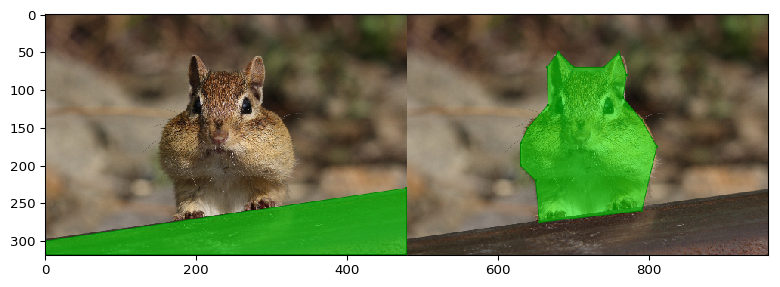

In [4]:
from imgaug.augmentables.polys import Polygon

# create polygons
poly_tree = Polygon(kpsoi_tree.keypoints)
poly_chipmunk = Polygon(kpsoi_chipmunk.keypoints)

# visualize polygons
ia.imshow(np.hstack([
    poly_tree.draw_on_image(image),
    poly_chipmunk.draw_on_image(image)
]))

Now we have to convert the two polygons to a single segmentation map. We do this by first creating an empty `(H,W,3)` array for our three classes (background, tree, chipmunk). Then we draw the tree and chipmunk polygons onto that array as if it was an image. We use 100% green (tree) and 100% blue (chipmunk) colors, thereby drawing the tree only into the second image channel and the chipmunk only into the third channel. Then we merge the three channels to a single segmentation map.

In [5]:
# create empty segmentation map for classes: background, tree, chipmunk
segmap = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

# draw the tree polygon into the second channel
segmap = poly_tree.draw_on_image(
    segmap,
    color=(0, 255, 0),
    alpha=1.0, alpha_lines=0.0, alpha_points=0.0)

# draw the chipmunk polygon into the third channel
segmap = poly_chipmunk.draw_on_image(
    segmap,
    color=(0, 0, 255),
    alpha=1.0, alpha_lines=0.0, alpha_points=0.0)

# merge the three channels to a single one
segmap = np.argmax(segmap, axis=2)

# change dtype from int64 to int32, as int32 is the allowed maximum in SegmentationMapsOnImage
segmap = segmap.astype(np.int32)

# draw statistics about our segmentation map
print("Shape:", segmap.shape, "min value:", segmap.min(), "max value:", segmap.max())

Shape: (319, 479) min value: 0 max value: 2


Now we just have to call `imgaug.augmentables.segmaps.SegmentationMapsOnImage` with that segmentation map and can draw the result on an image.

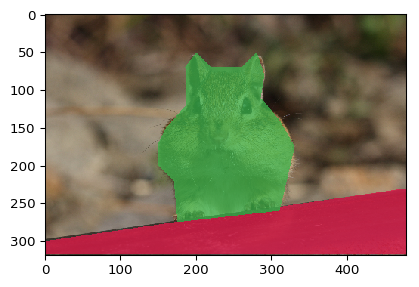

In [6]:
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

# convert array to SegmentationMapsOnImage instance
segmap = SegmentationMapsOnImage(segmap, shape=image.shape)

# visualize
# Note that the segmentation map drawing methods return lists of RGB images.
# That is because the segmentation map may have multiple channels
# -- the C in (H,W,C) -- and one image is drawn for each of these channels.
# We have C=1 here, so we get a list of a single image here and acces that via [0].
ia.imshow(segmap.draw_on_image(image)[0])

## Augment the Example Segmentation Map

After creating the example segmentation map, our next goal is to augment it (and the corresponding image). First, we create the augmentation sequence, consisting of a bit of coarse dropout (sets rectangular areas to zero), an affine transformation and an elastic transformation (water-like effect). Note that only `Affine` and `ElasticTransformation` will actually change the segmentation map, as segmentation map augmentation is only affected by augmenters that change the image geometry.

In [7]:
import imgaug.augmenters as iaa
ia.seed(2)

seq = iaa.Sequential([
    iaa.CoarseDropout(0.1, size_percent=0.2),
    iaa.Affine(rotate=(-30, 30)),
    iaa.ElasticTransformation(alpha=10, sigma=1)
])

Our next step is to apply the augmentation pipeline to both segmentation map and image. To do that we use `seq.augment(image=..., segmentation_maps=...)` or its shortcut `seq(image=..., segmentation_maps=...)`:

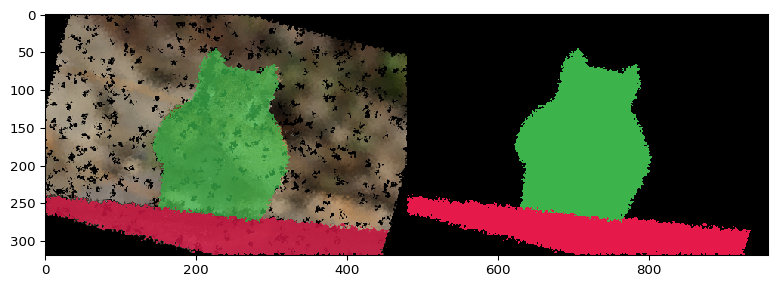

In [8]:
image_aug, segmap_aug = seq(image=image, segmentation_maps=segmap)

# visualize
ia.imshow(np.hstack([
    segmap_aug.draw_on_image(image_aug)[0],  # show blend of (augmented) image and segmentation map
    segmap_aug.draw()[0]  # show only the augmented segmentation map
]))

Note how the segmentation map is affected by the affine transformation (i.e. rotated) and the elastic transformation (i.e. water-like effect, here fairly noisy). It is not affected by coarse dropout as that augmenter does not change the image geometry. (Note also that coarse dropout here did drop rectangular areas, which appear non-rectangular as the elastic transformation was applied afterwards and roughened up the rectangles.)

The elastic transformation above is quite noisy, making it hard to see whether image and segmentation map augmentation are aligned. Let's execute it on its own with less noisy settings. Let's also generate one output image where the input image and segmentation map are both augmented on their own, which will result in different sampled random values and hence unaligned augmentations.

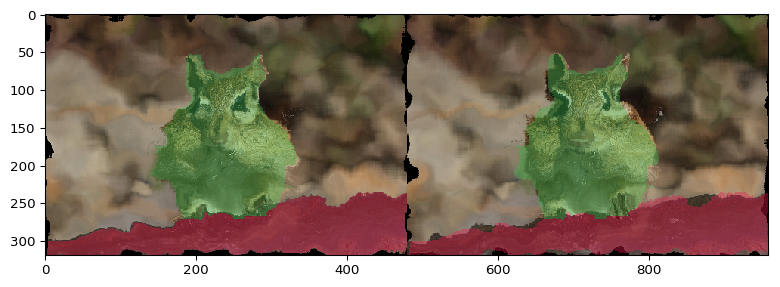

In [9]:
aug = iaa.ElasticTransformation(alpha=200, sigma=10)

# with alignment (correct)
image_aug, segmap_aug = aug(image=image, segmentation_maps=segmap)

# without to_deterministic() (incorrect)
image_aug_unaligned = aug(image=image)
segmap_aug_unaligned = aug(segmentation_maps=segmap)

ia.imshow(
    np.hstack([
        segmap_aug.draw_on_image(image_aug, alpha=0.4)[0],
        segmap_aug.draw_on_image(image_aug_unaligned, alpha=0.4)[0]
    ])
)

As you can see, there are significant differences between image and segmentation map in the right image (well visible e.g. for the tree). While in the version with aligned sampled values (left) image and segmentation map match well.

## Scaling Segmentation Maps

Segmentation maps often have to be resized, e.g. to create lower-resolution ground truth outputs for a network. This can be done using the `resize()` method. The following example uses the method to resize a segmentation map to 1/4th of its original size. Alternatively, a fixed size can also be used (e.g. `(100, 200)` to get an output map with height 100 and width 200).

In [10]:
segmap_small = segmap.resize(0.25)
print("Before:", segmap.arr.shape, "After:", segmap_small.arr.shape)

Before: (319, 479, 1) After: (80, 120, 1)


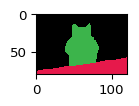

In [11]:
ia.imshow(segmap_small.draw()[0])

Let's visualize the segmentation map before and after resizing, projected onto the image (i.e. again resized, back to the image size). The map after downscaling+upscaling (right) is visibly more coarse than the one without (left).

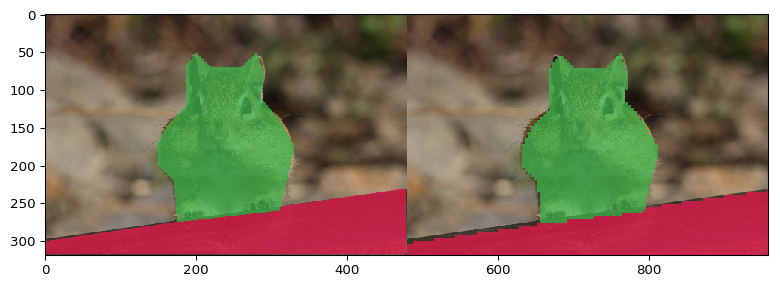

In [12]:
ia.imshow(
    np.hstack([
        segmap.draw_on_image(image)[0],
        segmap_small.draw_on_image(image)[0]
    ])
)

## Augment Segmentation Maps Smaller than their Corresponding Image

It is quite common that the ground truth output segmentation map of a network is smaller than the input image. This scenario is handled automatically by `imgaug`. Simply feed the smaller-sized segmentation map through the augmentation pipeline as if it was of the same size as the image. Just make sure that the `.shape` attribute of `SegmentationMapsOnImage` matches the input image size (as it always should).

The following code block augments the example image and the previously downscaled segmentation map. We first print the array shapes:

In [13]:
print("Image size: %s Segmentation Map size: %s (on image with shape: %s)" % (
    image.shape, segmap_small.arr.shape, segmap_small.shape))

Image size: (319, 479, 3) Segmentation Map size: (80, 120, 1) (on image with shape: (319, 479, 3))


And now we augment and visualize the image and the small scale segmentation map.

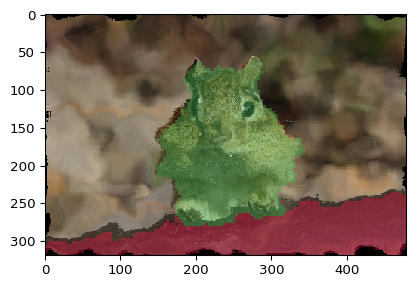

In [14]:
aug = iaa.ElasticTransformation(alpha=200, sigma=10)

image_aug, segmap_small_aug = aug(image=image, segmentation_maps=segmap_small)

ia.imshow(segmap_small_aug.draw_on_image(image_aug, alpha=0.4)[0])

Augmentation of smaller sized segmentation maps still works, even if parameters denote pixel values. The following example shows a common scenario where the image is cropped by a set amount of pixels (50 at the bottom, 200 on the left side). The pixel amounts are transformed to corresponding pixel amounts for the smaller sized segmentation map. (For comparison, we also augment the image-sized segmentation map.)

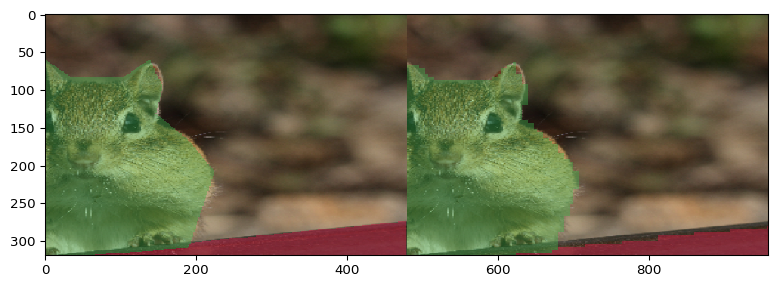

In [15]:
aug = iaa.Crop(px=(0, 0, 50, 200))  # (top, right, bottom, left)

# We have to augment two segmentation maps with the exactly same random values.
# This is why we switch to deterministic mode here, which resets the random state after
# each augmentation.
# (Due to using non-stochastic crop values, we could also skip this, but it seems cleaner
# to do it.)
aug_det = aug.to_deterministic()
image_aug = aug_det.augment_image(image)  # augment image
segmap_aug = aug_det.augment_segmentation_maps(segmap)  # augment normal-sized segmentation map
segmap_small_aug = aug_det.augment_segmentation_maps(segmap_small)  # augment smaller-sized segmentation map

ia.imshow(np.hstack([
    segmap_aug.draw_on_image(image_aug, alpha=0.4)[0],  # draw augmented normal-sized segmentation map
    segmap_small_aug.draw_on_image(image_aug, alpha=0.4)[0]  # draw augmented smaller-sized segmentation map
]))

Even though both augmented segmentation maps (left: normal scale, right: small scale) were here automatically upscaled to the image size and hence both *seem* to have the same resolution, the smaller segmentation map (right) has visibly rougher edges due to its actually lower resolution *before automatic upscaling*.

## Convert Augmented Segmentation Maps to Numpy Arrays

The internal array in `SegmentationMapsOnImage`, accessible via the `.arr` attribute, has by default dtype `int32` and shape `(H,W,C)`. If the original array that was to the constructor of `SegmentationMapsOnImage` had the same dtype and shape, you may simply access `.arr`. Otherwise, you should call `get_arr()`, which automatically converts `.arr` to your original dtype and shape. (To be precise: It doesn't convert to the original shape, but to the original number of dimensions. The shape might have changed after creating the object due to resizing operations.)

In [16]:
arr = segmap.arr
arr_int = segmap.get_arr()

print("[segmap.arr]       Shape:", arr.shape, "dtype:", arr.dtype)
print("[segmap.get_arr()] Shape:", arr_int.shape, "dtype:", arr_int.dtype)

[segmap.arr]       Shape: (319, 479, 1) dtype: int32
[segmap.get_arr()] Shape: (319, 479) dtype: int32


## Pad Segmentation Maps

Similarly to images, segmentation maps can be padded using `SegmentationMapsOnImage.pad()`. Padding supports several different modes, with the most appropriate ones often being `constant` (pad with a constant value `cval`) and `edge` (keep repeating the class ids around the image borders). The following example showcases both of these modes. It first pads both image and segmentation map with a constant value of `0` (left image) and afterwards pads them using `edge` mode (right image).

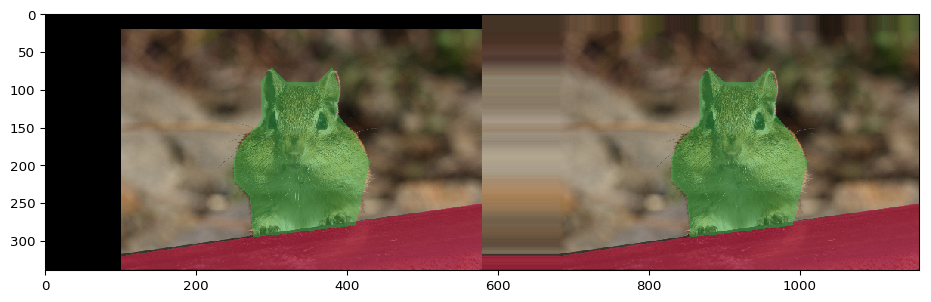

In [17]:
image_pad_constant = ia.pad(image, left=100, top=20)  # mode="constant" and cval=0 are the defaults of pad()
segmap_pad_constant = segmap.pad(left=100, top=20)    # mode="constant" and cval=0 are the defaults of pad()

image_pad_edge = ia.pad(image, left=100, top=20, mode="edge")
segmap_pad_edge = segmap.pad(left=100, top=20, mode="edge")

ia.imshow(np.hstack([
    segmap_pad_constant.draw_on_image(image_pad_constant, alpha=0.5)[0],
    segmap_pad_edge.draw_on_image(image_pad_edge, alpha=0.5)[0],
]))

When using edge mode, one has to be careful with classes that do not fully extend to the image edges. The below example pads image and segmentation map using `edge` mode, but now pads on the left *and* the right side. While the padding of the segmentation map behaves as expected on the left side, it does not extend the class on the right side.

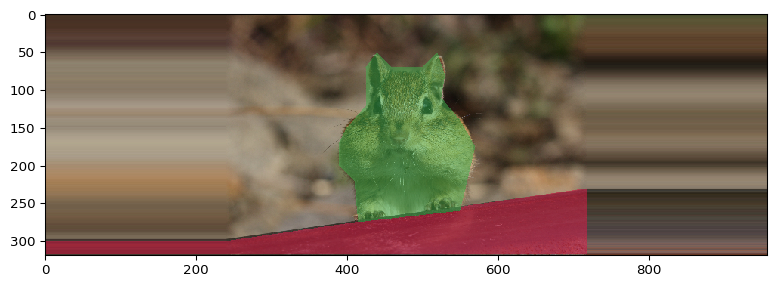

In [18]:
image_wide = ia.pad_to_aspect_ratio(image, 3.0, mode="edge")
segmap_wide = segmap.pad_to_aspect_ratio(3.0, mode="edge")

ia.imshow(segmap_wide.draw_on_image(image_wide, alpha=0.5)[0])

The reason for the above problem is that the drawing routine, which was used to add the tree polygon to the segmentation map, stopped just slightly short of the right image edge. The output below demonstrates this. It shows the class ids for the last five columns of the segmentation map. The tree class extends only up to the second to last column.

In [19]:
print(segmap.arr[:, -5:, 0])

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 ...
 [1 1 1 1 0]
 [1 1 1 1 0]
 [0 0 0 0 0]]


## Draw Segmentation Maps

The above examples already made use of the drawing methods offered by `SegmentationMapsOnImage`. One of these methods is `draw()`, which converts the segmentation map to a list of RGB images. For a `(H,W,C)` segmentation map it returns `C` RGB images. In most cases, `C` is `1` and hence the list only contains a single image.
The example below uses the `draw()` method to visualize a segmentation map before and after augmentation:

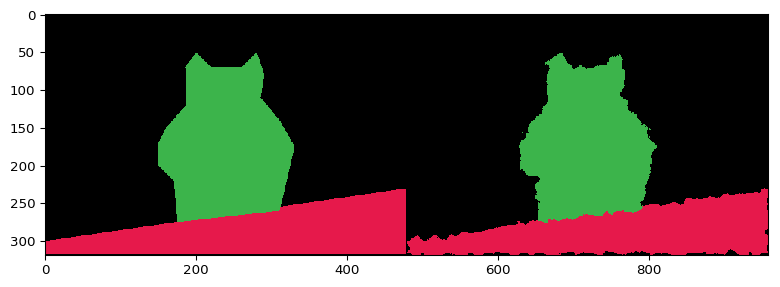

In [20]:
segmap_aug = iaa.ElasticTransformation(alpha=50, sigma=5).augment_segmentation_maps(segmap)
ia.imshow(np.hstack([
    segmap.draw()[0],
    segmap_aug.draw()[0],
]))

In case other colors than the default ones are desired, the parameter `colors` can be used to define them. It expects a list with one iterable per class. Each iterable must contain three `uint8` values.

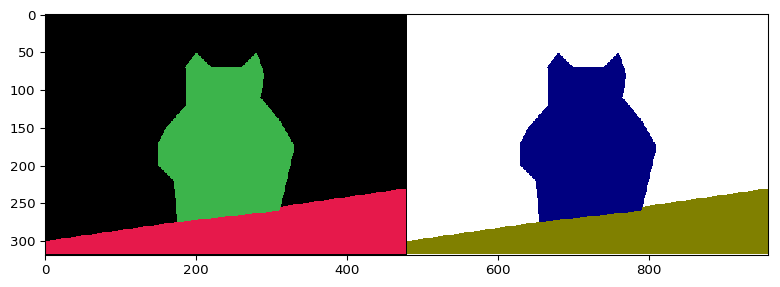

In [21]:
ia.imshow(np.hstack([
    segmap.draw()[0],
    segmap.draw(colors=[(255, 255, 255), (128, 128, 0), (0, 0, 128)])[0],
]))

For easy scaling, `draw` also offers a `size` parameter, which can be set to e.g. a `(height, width)` tuple or a fraction (relative to the size saved in `SegmentationMapsOnImage.shape`), as in the following example:

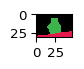

In [22]:
ia.imshow(segmap.draw(0.1)[0])

The method `draw_on_image()` is similar to `draw()`, but is geared towards visualizing the segmentation map ontop of another image. The method performs the following three steps: (1) It converts the segmentation map to a list of RGB images (like `draw()` does), then (2) it resizes each of them to the same size as the provided base image (or it resizes the base image to the drawn segmentation map sizes, depending on arguments), and then (3) it alpha-blends the image and segmentation map images.
The following example showcases `draw_on_image()`. Note that the background (class id `0`) is by default set to transparent.

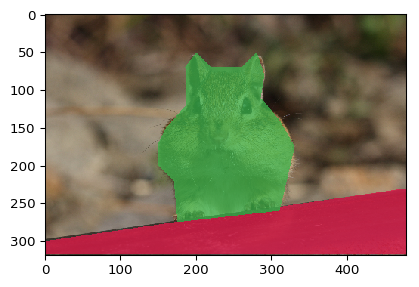

In [23]:
ia.imshow(segmap.draw_on_image(image)[0])

In the alpha blending step, the segmentation map's opacity can be controlled using the `alpha` argument:

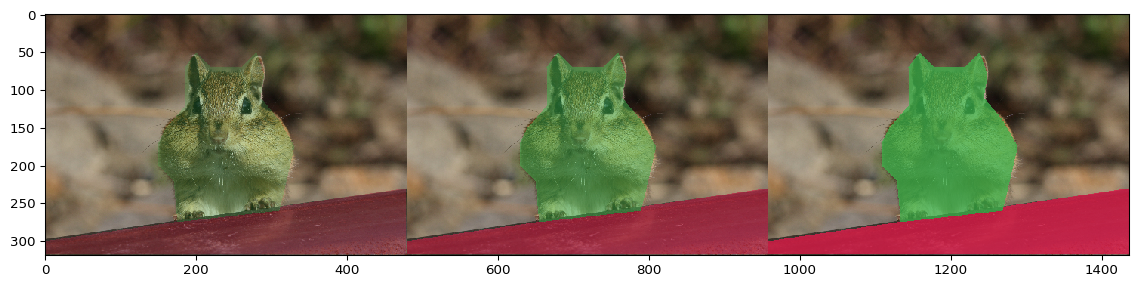

In [24]:
ia.imshow(np.hstack([
    segmap.draw_on_image(image, alpha=0.25)[0],
    segmap.draw_on_image(image, alpha=0.50)[0],
    segmap.draw_on_image(image, alpha=0.75)[0]
]))

Usually, pixels with the background class id `0` are set to transparent, i.e. they show the base image. These background class pixels of the segmentation map image can also be drawn by setting `draw_background=True`. The default color for the background is black.

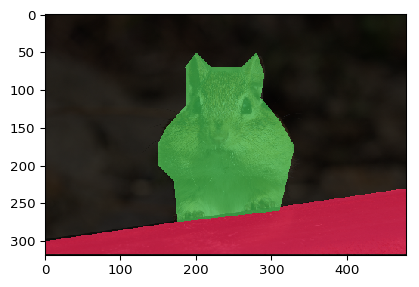

In [25]:
ia.imshow(segmap.draw_on_image(image, draw_background=True)[0])

Alternatively, using `background_class_id` it is possible to control which class is supposed to be treated as background and hence ignored in the blending.

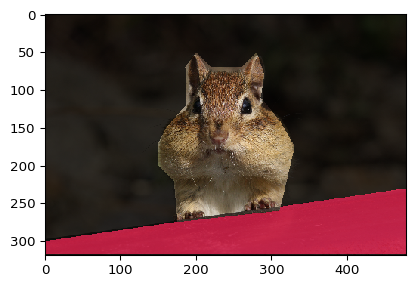

In [26]:
ia.imshow(segmap.draw_on_image(image, draw_background=False, background_class_id=2)[0])

`draw_on_image()` can handle different sizes between image and segmentation map. By default, the segmentation map is resized to the image size using nearest neighbour interpolation. The following example uses a segmentation map with 20% of the image size to show this:

(64, 96, 1) (319, 479, 3)


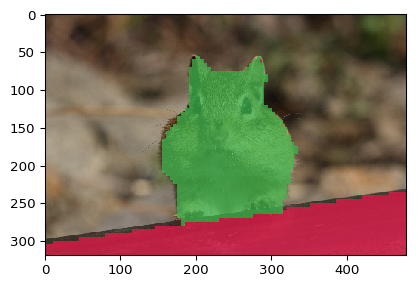

In [27]:
segmap_small = segmap.resize(0.2)
print(segmap_small.arr.shape, image.shape)

ia.imshow(segmap_small.draw_on_image(image)[0])

Instead of resizing the segmentation map to the image, the image can instead be resized to the segmentation map's size using the `resize` argument:

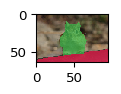

In [28]:
ia.imshow(segmap_small.draw_on_image(image, resize="image")[0])

## Change Segmentation Maps with Non-Geometric Augmentations

By default, the segmentation map augmentation using `augment(segmentation_maps=...)` or `augment_segmentation_maps(...)` is geared towards ground truth augmentation and hence only applies geometry-affecting augmentations. If that limitation is undesired, the segmentation maps have to be treated as raw arrays and fed through `augment(images=...)` or `augment_images(...)`. The following code block first introduces an example using ordinary `augment(image=..., segmentation_maps=...)`. In second code block, this is then changed to using two times `augment(image=...)`.

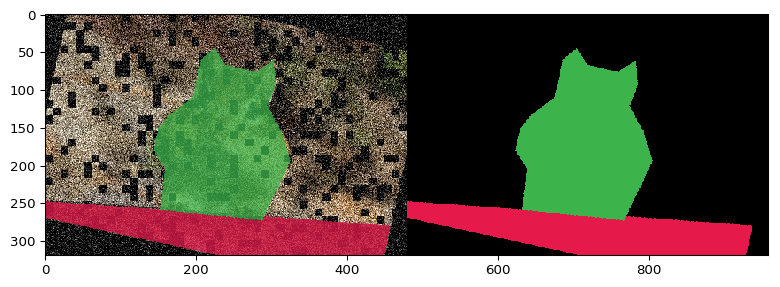

In [29]:
# example augmentation pipeline
aug = iaa.Sequential([
    iaa.Affine(rotate=(-20, 20)),  # only this affects segmentation maps via augment_segmentation_maps()
    iaa.CoarseDropout(0.2, size_percent=0.1),
    iaa.AdditiveGaussianNoise(scale=0.2*255)
])

# standard way of augmenting segmentation maps via augment_segmentation_maps()
image_aug, segmap_aug = aug(image=image, segmentation_maps=segmap)

# visualize before/after
ia.imshow(np.hstack([
    segmap_aug.draw_on_image(image_aug)[0],
    segmap_aug.draw()[0]
]))

Now we augment the segmentation maps with `Affine` and the non-geometric `CoarseDropout`. However, we do not want to apply `AdditiveGaussianNoise` to the segmentation maps, only to the images. A fairly simple way to achieve this is to use two different augmentation pipelines, one for images and one for segmentation maps. We then initialize each augmenter with a hand-adjusted seed via `random_state=<seed>`. By choosing matching seeds between the two pipelines, we can ensure that the augmenters draw the same samples.

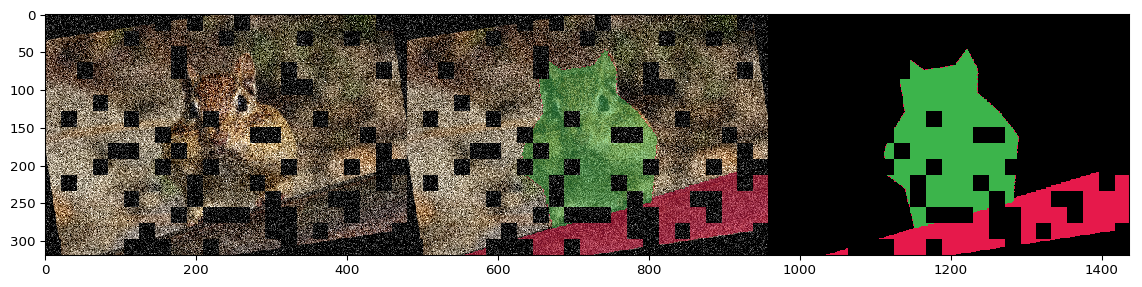

In [30]:
# augmentation pipeline for images
aug_images = iaa.Sequential([
    iaa.Affine(rotate=(-20, 20), random_state=1),
    iaa.CoarseDropout(0.2, size_percent=0.05, random_state=2),
    iaa.AdditiveGaussianNoise(scale=0.2*255, random_state=3)
], random_state=4)

# augmentation pipeline for segmentation maps - with coarse dropout, but without gaussian noise
aug_segmaps = iaa.Sequential([
    iaa.Affine(rotate=(-20, 20), random_state=1),
    iaa.CoarseDropout(0.2, size_percent=0.05, random_state=2)
], random_state=4)

# First, augment image.
image_aug = aug_images(image=image)

# Second, augment segmentation map.
# We convert to uint8 as that dtype has usually best support and hence is safest to use.
segmap_arr_aug = aug_segmaps(image=segmap.get_arr().astype(np.uint8))
segmap_aug = SegmentationMapsOnImage(segmap_arr_aug, shape=segmap.shape)

# visualize
ia.imshow(np.hstack([
    image_aug,
    segmap_aug.draw_on_image(image_aug, alpha=0.5)[0],
    segmap_aug.draw()[0]
]))

Note that when augmenting segmentation maps via `augment(image=...)` or `augment_images(...)`, size differences are not automatically accounted for. So while augmentations via `augment(segmentation_maps=...)` or `augment_segmentation_maps(...)` can be done with segmentation maps that are smaller than the corresponding images, the sizes should match if using the former image-based methods. Otherwise, the two pipelines have to be manually adjusted to match despite different sizes. E.g. `Crop` should then be used with fractions instead of raw pixel values as arguments -- or alternatively the pixel values have to be different between the pipelines.